In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns

In [2]:
master_data = pd.read_csv('cleaned_master_data.csv')

In [41]:
print("Event Data:")
display(master_data.head())

Event Data:


,date,result,fighter,opponent,division,stance,dob,method,total_comp_time,round,...,leg_strikes_attempts,distance_strikes_landed,distance_strikes_attempts,clinch_strikes_landed,clinch_strikes_attempts,ground_strikes_landed,ground_strikes_attempts,total_seconds,fight_gap,frequent_long_fights
0,2022-02-12,0,AJ Dobson,Jacob Malkoun,Middleweight,orthodox,1992-01-18,U-DEC,900,3,...,5,44,78,5,9,3,3,300,NaN,No Long Fights
1,2022-03-12,0,AJ Fletcher,Matthew Semelsberger,Welterweight,switch,1997-02-18,U-DEC,900,3,...,11,30,58,0,1,4,5,300,NaN,No Long Fights
2,2020-02-29,0,Aalon Cruz,Spike Carlyle,Featherweight,switch,1989-09-20,KO/TKO,85,1,...,4,2,12,0,0,0,0,85,NaN,No Long Fights
3,2021-03-06,0,Aalon Cruz,Uros Medic,Lightweight,switch,1989-09-20,KO/TKO,100,1,...,0,0,3,0,0,0,0,100,371.0,No Long Fights
4,2000-11-17,0,Aaron Brink,Andrei Arlovski,Heavyweight,orthodox,1974-11-12,SUB,55,1,...,0,0,3,0,2,0,0,55,NaN,No Long Fights


In [42]:
print(master_data.columns)

Index(['date', 'result', 'fighter', 'opponent', 'division', 'stance', 'dob',
       'method', 'total_comp_time', 'round', 'time', 'referee', 'time_format',
       'reach', 'height', 'age', 'knockdowns', 'sub_attempts', 'reversals',
       'control', 'takedowns_landed', 'takedowns_attempts',
       'sig_strikes_landed', 'sig_strikes_attempts', 'total_strikes_landed',
       'total_strikes_attempts', 'head_strikes_landed',
       'head_strikes_attempts', 'body_strikes_landed', 'body_strikes_attempts',
       'leg_strikes_landed', 'leg_strikes_attempts', 'distance_strikes_landed',
       'distance_strikes_attempts', 'clinch_strikes_landed',
       'clinch_strikes_attempts', 'ground_strikes_landed',
       'ground_strikes_attempts', 'total_seconds', 'fight_gap',
       'frequent_long_fights'],
      dtype='object')


### Knockdowns and Win Outcome


In [4]:
filtered_data = master_data.dropna(subset=['knockdowns'])

filtered_data['is_winner'] = filtered_data['result'].apply(lambda x: 1 if x == 1 else 0)

In [5]:
grouped_data = filtered_data.groupby('fighter').agg(
    total_knockdowns=('knockdowns', 'sum'),
    total_fights=('result', 'count'),
    total_wins=('is_winner', 'sum')
).reset_index()

In [6]:
grouped_data['win_ratio'] = grouped_data['total_wins'] / grouped_data['total_fights']

In [7]:
knockdown_bins = [0, 1, 3, float('inf')]
knockdown_labels = ['0-1', '2-3', '4+']
grouped_data['knockdown_category'] = pd.cut(grouped_data['total_knockdowns'], bins=knockdown_bins, labels=knockdown_labels)

In [8]:
knockdown_vs_win_ratio = grouped_data.groupby('knockdown_category')['win_ratio'].mean().reset_index()

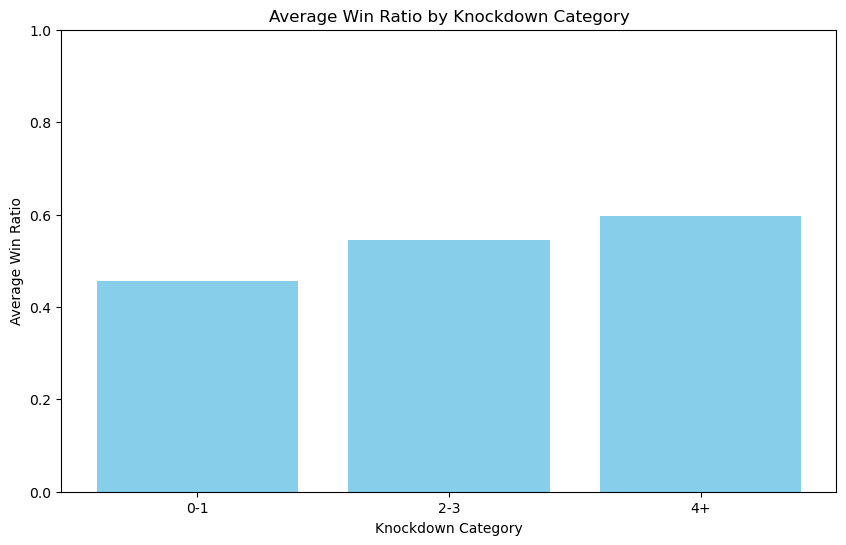

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(knockdown_vs_win_ratio['knockdown_category'], knockdown_vs_win_ratio['win_ratio'], color='skyblue')
plt.xlabel('Knockdown Category')
plt.ylabel('Average Win Ratio')
plt.title('Average Win Ratio by Knockdown Category')
plt.ylim(0, 1)
plt.show()

In [10]:
contingency_table = pd.crosstab(grouped_data['knockdown_category'], grouped_data['total_wins'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [11]:
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

Chi-Square Statistic: 426.76143074375665
P-Value: 3.6946987903593754e-63


### How do fight outcomes differ based on stances like Orthodox, Southpaw, and Switch?  

In [12]:
filtered_stance_data = master_data.dropna(subset=['stance', 'result'])
filtered_stance_data['is_winner'] = filtered_stance_data['result'].apply(lambda x: 1 if x == 1 else 0)
stance_analysis = filtered_stance_data.groupby('stance').agg(
    total_fights=('result', 'count'),
    total_wins=('is_winner', 'sum')
).reset_index()

stance_analysis['win_ratio'] = stance_analysis['total_wins'] / stance_analysis['total_fights']


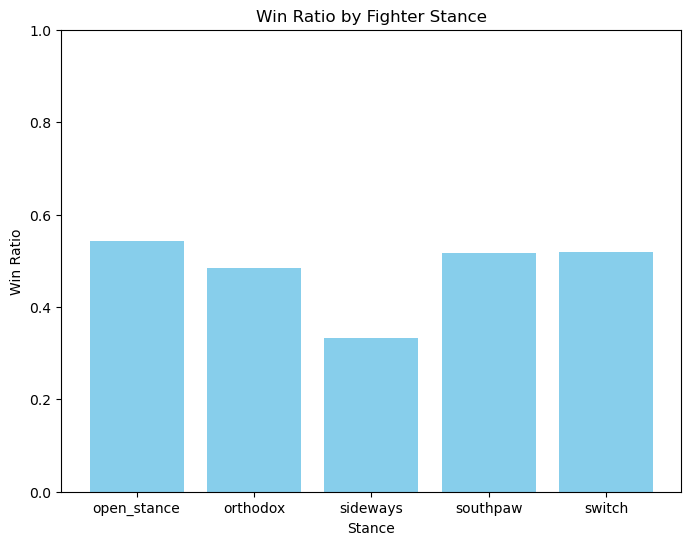

In [13]:
plt.figure(figsize=(8, 6))
plt.bar(stance_analysis['stance'], stance_analysis['win_ratio'], color='skyblue')
plt.xlabel('Stance')
plt.ylabel('Win Ratio')
plt.title('Win Ratio by Fighter Stance')
plt.ylim(0, 1)
plt.show()

In [14]:
print(stance_analysis)

        stance  total_fights  total_wins  win_ratio
0  open_stance            24          13   0.541667
1     orthodox         10079        4871   0.483282
2     sideways             6           2   0.333333
3     southpaw          2634        1360   0.516325
4       switch           552         287   0.519928


### What impact does age have on a fighter’s success, especially comparing fighters under 20 vs. over 20?  

In [15]:
filtered_age_data = master_data[(master_data['age'] > 0) & (master_data['result'].notna())].copy()
filtered_age_data['is_winner'] = filtered_age_data['result'].apply(lambda x: 1 if x == 1 else 0)
filtered_age_data['age_group'] = filtered_age_data['age'].apply(lambda x: 'Under 20' if x < 20 else 'Over 20')

age_analysis = filtered_age_data.groupby('age_group').agg(
    total_fights=('result', 'count'),
    total_wins=('is_winner', 'sum')
).reset_index()

age_analysis['win_ratio'] = age_analysis['total_wins'] / age_analysis['total_fights']

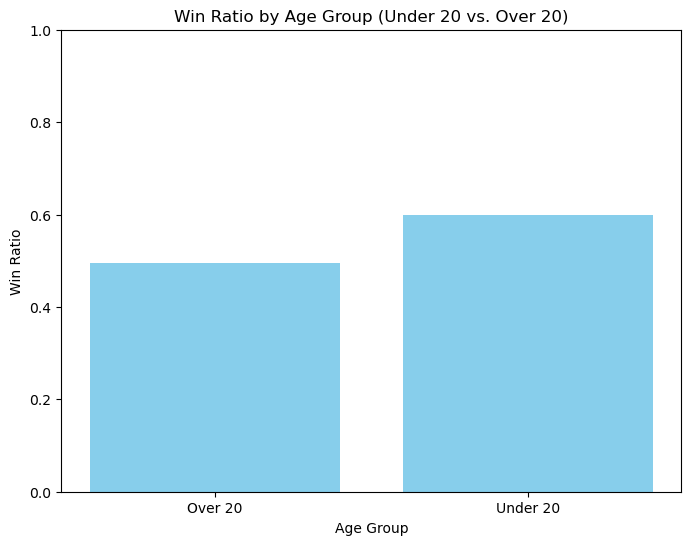

In [16]:
plt.figure(figsize=(8, 6))
plt.bar(age_analysis['age_group'], age_analysis['win_ratio'], color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Win Ratio')
plt.title('Win Ratio by Age Group (Under 20 vs. Over 20)')
plt.ylim(0, 1)
plt.show()

In [17]:
print(age_analysis)

  age_group  total_fights  total_wins  win_ratio
0   Over 20         13063        6469   0.495215
1  Under 20            10           6   0.600000


### Stance Usage by Age Group

In [18]:
# filtered_stance_data = master_data.dropna(subset=['age', 'stance'])
# age_bins = np.linspace(filtered_stance_data['age'].min(), filtered_stance_data['age'].max(), 11)  # 10 bins
# age_labels = [f"{round(age_bins[i], 1)} - {round(age_bins[i+1], 1)}" for i in range(len(age_bins)-1)]
# filtered_stance_data['age_group'] = pd.cut(filtered_stance_data['age'], bins=age_bins, labels=age_labels, include_lowest=True)

# stance_analysis = filtered_stance_data.groupby(['age_group', 'stance']).size().reset_index(name='count')
# stance_analysis['proportion'] = stance_analysis.groupby('age_group')['count'].transform(lambda x: x / x.sum())



In [19]:
#  plt.figure(figsize=(12, 8))
#  sns.barplot(data=stance_analysis, x='age_group', y='proportion', hue='stance')
# plt.xlabel('Age Group (years)')
# plt.ylabel('Proportion of Stance Usage')
# plt.title('Proportion of Stance Usage by Age Group')
# plt.xticks(rotation=45, ha='right')
# plt.legend(title='Stance', loc='upper right')
# plt.tight_layout()
# plt.show()

### Stance Usage by Age Group (OVERLOOKING THE 0'S IN THE DATASET)

In [20]:
filtered_stance_data = master_data[(master_data['age'] > 0) & (master_data['stance'].notna())].copy()

age_bins = np.linspace(filtered_stance_data['age'].min(), filtered_stance_data['age'].max(), 11)  # 10 bins
age_labels = [f"{round(age_bins[i], 1)} - {round(age_bins[i+1], 1)}" for i in range(len(age_bins)-1)]

filtered_stance_data.loc[:, 'age_group'] = pd.cut(filtered_stance_data['age'], bins=age_bins, labels=age_labels, include_lowest=True)

stance_analysis = filtered_stance_data.groupby(['age_group', 'stance']).size().reset_index(name='count')

stance_analysis['proportion'] = stance_analysis.groupby('age_group')['count'].transform(lambda x: x / x.sum())


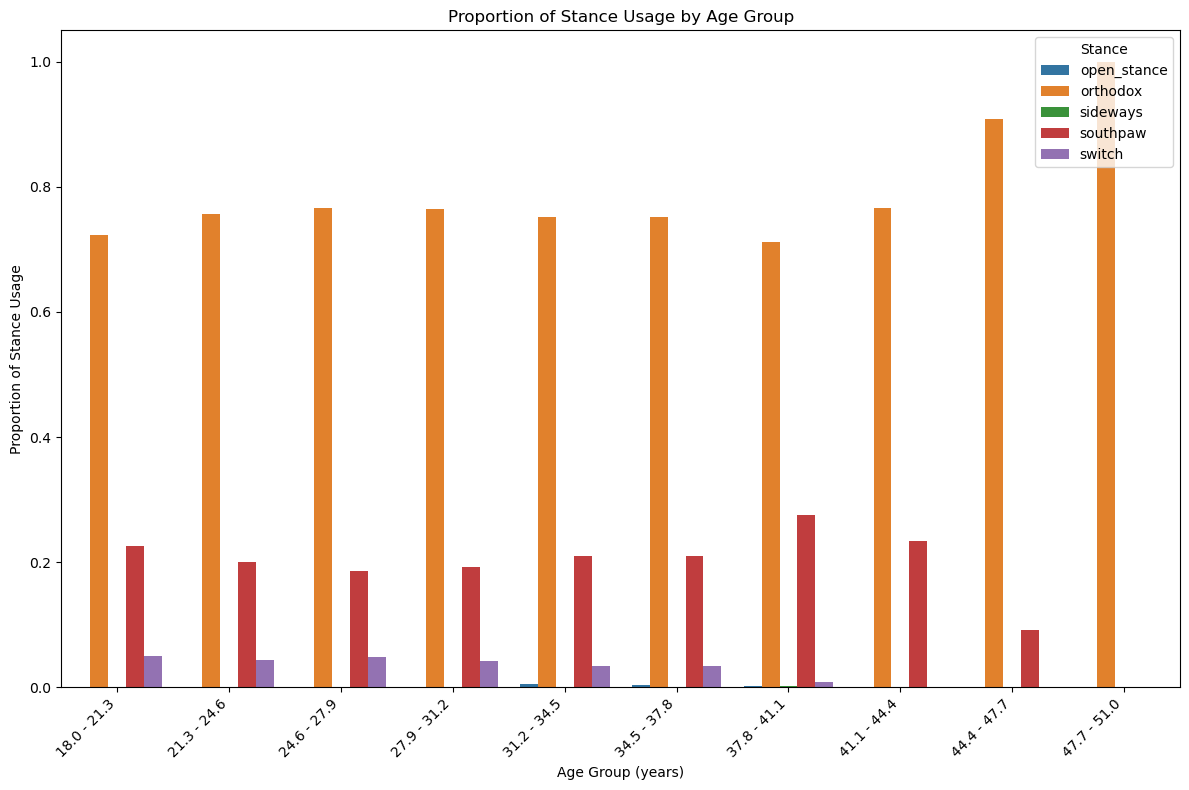

In [21]:
plt.figure(figsize=(12, 8))
sns.barplot(data=stance_analysis, x='age_group', y='proportion', hue='stance')
plt.xlabel('Age Group (years)')
plt.ylabel('Proportion of Stance Usage')
plt.title('Proportion of Stance Usage by Age Group')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stance', loc='upper right')
plt.tight_layout()
plt.show()

In [22]:
print(stance_analysis)

      age_group       stance  count  proportion
0   18.0 - 21.3  open_stance      0    0.000000
1   18.0 - 21.3     orthodox    115    0.723270
2   18.0 - 21.3     sideways      0    0.000000
3   18.0 - 21.3     southpaw     36    0.226415
4   18.0 - 21.3       switch      8    0.050314
5   21.3 - 24.6  open_stance      0    0.000000
6   21.3 - 24.6     orthodox    894    0.756345
7   21.3 - 24.6     sideways      0    0.000000
8   21.3 - 24.6     southpaw    237    0.200508
9   21.3 - 24.6       switch     51    0.043147
10  24.6 - 27.9  open_stance      2    0.000690
11  24.6 - 27.9     orthodox   2220    0.765517
12  24.6 - 27.9     sideways      0    0.000000
13  24.6 - 27.9     southpaw    538    0.185517
14  24.6 - 27.9       switch    140    0.048276
15  27.9 - 31.2  open_stance      3    0.000626
16  27.9 - 31.2     orthodox   3665    0.764976
17  27.9 - 31.2     sideways      0    0.000000
18  27.9 - 31.2     southpaw    918    0.191609
19  27.9 - 31.2       switch    205    0

### Individual Career Longevity (Royce Gracie)

In [23]:
master_data['date'] = pd.to_datetime(master_data['date'])
royce_data = master_data[master_data['fighter'] == 'Royce Gracie'].copy()
royce_data['year'] = royce_data['date'].dt.year

royce_stats_by_year = royce_data.groupby('year').agg(
    total_fights=('result', 'count'),
    total_wins=('result', lambda x: sum(x == 1)),
    total_strikes_landed=('total_strikes_landed', 'sum'),
    total_strikes_attempted=('total_strikes_attempts', 'sum'),
    knockdowns=('knockdowns', 'sum'),
    submissions=('sub_attempts', 'sum'),
    control_time=('control', 'sum')
).reset_index()

royce_stats_by_year['strike_accuracy'] = royce_stats_by_year['total_strikes_landed'] / royce_stats_by_year['total_strikes_attempted']

print(royce_stats_by_year)


   year  total_fights  total_wins  total_strikes_landed  \
0  1994             8           8                   290   
1  2006             1           0                    14   

   total_strikes_attempted  knockdowns  submissions  control_time  \
0                      319           0           12             0   
1                       18           0            0             0   

   strike_accuracy  
0         0.909091  
1         0.777778  


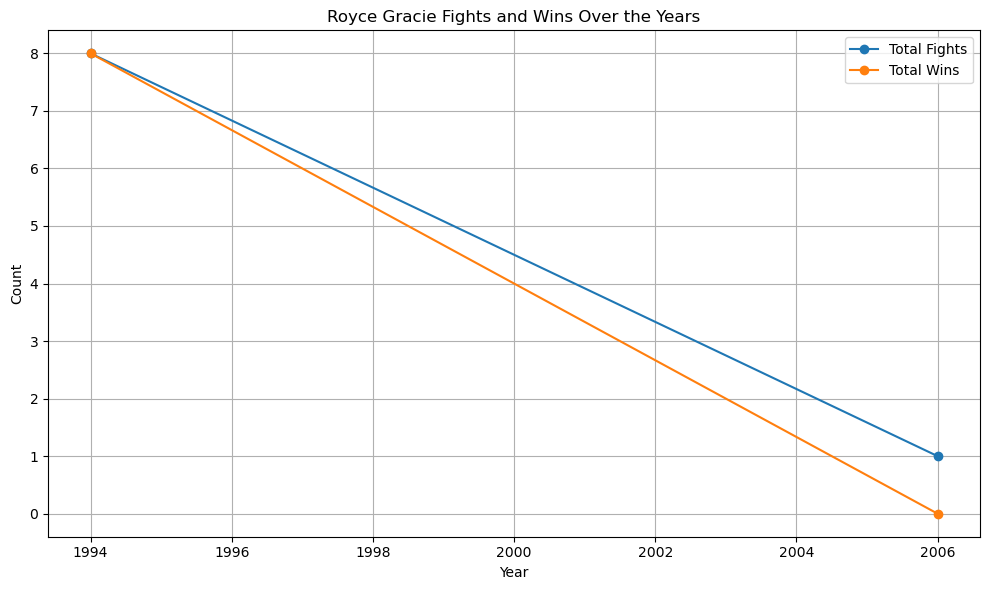

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(royce_stats_by_year['year'], royce_stats_by_year['total_fights'], label='Total Fights', marker='o')
plt.plot(royce_stats_by_year['year'], royce_stats_by_year['total_wins'], label='Total Wins', marker='o')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Royce Gracie Fights and Wins Over the Years')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


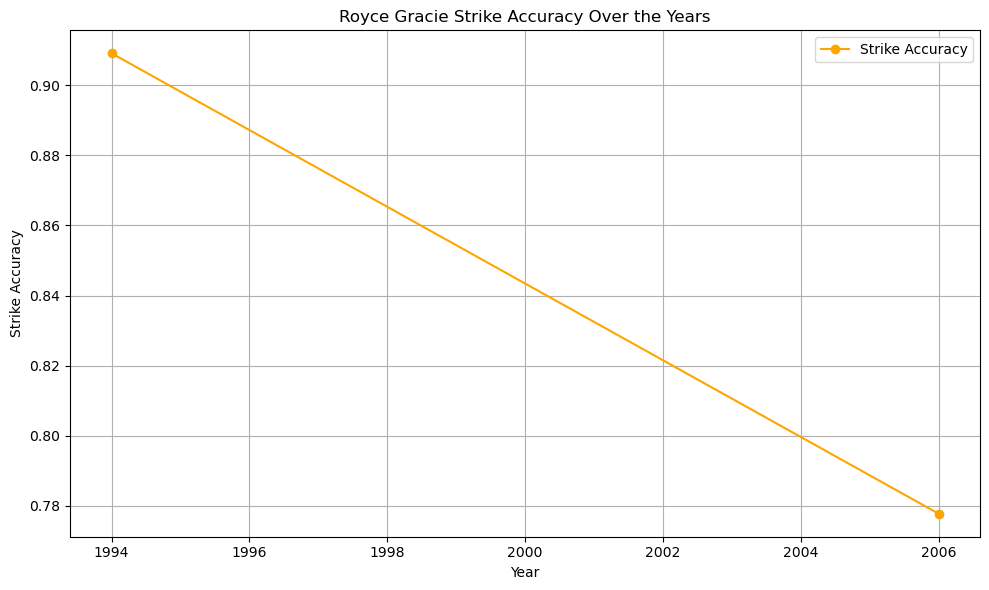

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(royce_stats_by_year['year'], royce_stats_by_year['strike_accuracy'], label='Strike Accuracy', marker='o', color='orange')
plt.xlabel('Year')
plt.ylabel('Strike Accuracy')
plt.title('Royce Gracie Strike Accuracy Over the Years')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Age vs. Strike Accuracy 

In [26]:
filtered_data = master_data[(master_data['age'] > 0) & (master_data['total_strikes_attempts'] > 0)].copy()
filtered_data['strike_accuracy'] = filtered_data['total_strikes_landed'] / filtered_data['total_strikes_attempts']
age_accuracy_analysis = filtered_data.groupby('age').agg(
    avg_strike_accuracy=('strike_accuracy', 'mean'),
    fight_count=('result', 'count')  # Optional, to see how many fights contribute to each age
).reset_index()


print(age_accuracy_analysis)


     age  avg_strike_accuracy  fight_count
0   18.0             0.296970            2
1   19.0             0.620109            8
2   20.0             0.537966           46
3   21.0             0.554809          102
4   22.0             0.559476          226
5   23.0             0.541213          391
6   24.0             0.543228          560
7   25.0             0.532319          788
8   26.0             0.534053          976
9   27.0             0.544333         1123
10  28.0             0.529131         1194
11  29.0             0.523214         1227
12  30.0             0.542378         1216
13  31.0             0.532609         1141
14  32.0             0.532355          980
15  33.0             0.535137          797
16  34.0             0.525906          672
17  35.0             0.548803          490
18  36.0             0.542094          391
19  37.0             0.518494          251
20  38.0             0.540590          164
21  39.0             0.536980          100
22  40.0   

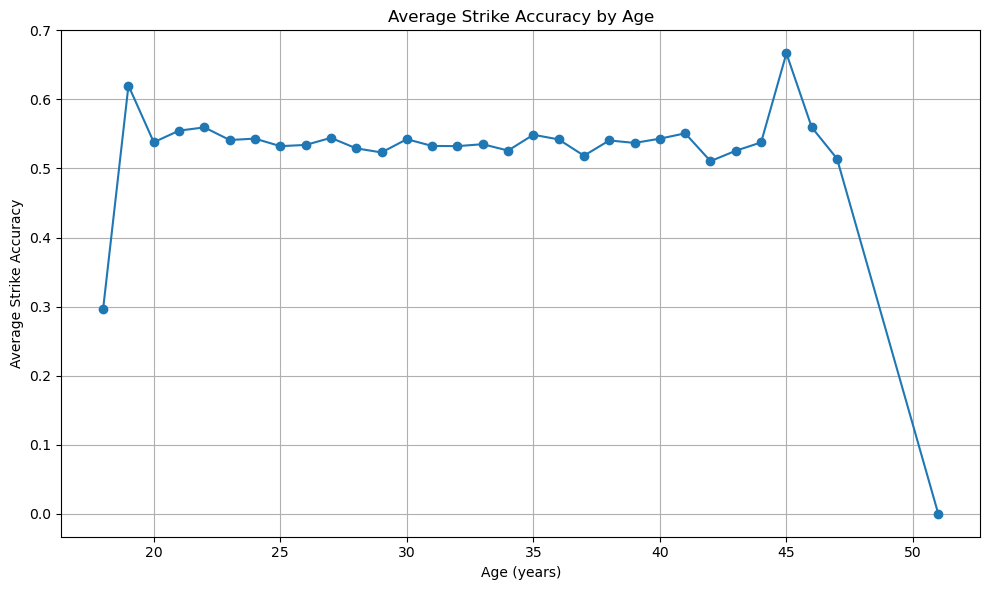

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(age_accuracy_analysis['age'], age_accuracy_analysis['avg_strike_accuracy'], marker='o', label='Strike Accuracy')
plt.xlabel('Age (years)')
plt.ylabel('Average Strike Accuracy')
plt.title('Average Strike Accuracy by Age')
plt.grid()
plt.tight_layout()
plt.show()

### Do older fighters rely more on technique (e.g., control and submissions) compared to younger fighters?


In [28]:
filtered_data = master_data[(master_data['age'] > 0) & (master_data['control'].notna()) & (master_data['sub_attempts'].notna())].copy()

age_bins = [0, 25, 34, float('inf')]  # Example age groups
age_labels = ['<25', '25-34', '35+']
filtered_data['age_group'] = pd.cut(filtered_data['age'], bins=age_bins, labels=age_labels, include_lowest=True)

technique_analysis = filtered_data.groupby('age_group').agg(
    avg_control_time=('control', 'mean'),
    avg_sub_attempts=('sub_attempts', 'mean'),
    total_fights=('result', 'count')  # Optional: Count of fights in each age group
).reset_index()

print(technique_analysis)

  age_group  avg_control_time  avg_sub_attempts  total_fights
0       <25        151.803379          0.599718          2131
1     25-34        131.932350          0.379929          9357
2       35+        120.696530          0.264353          1585


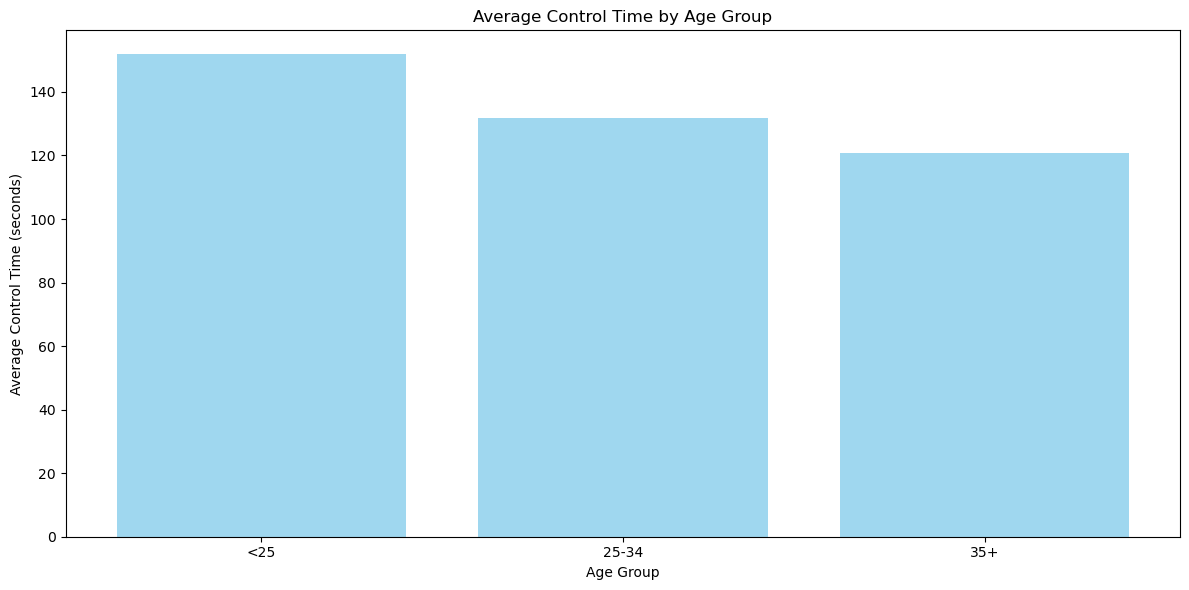

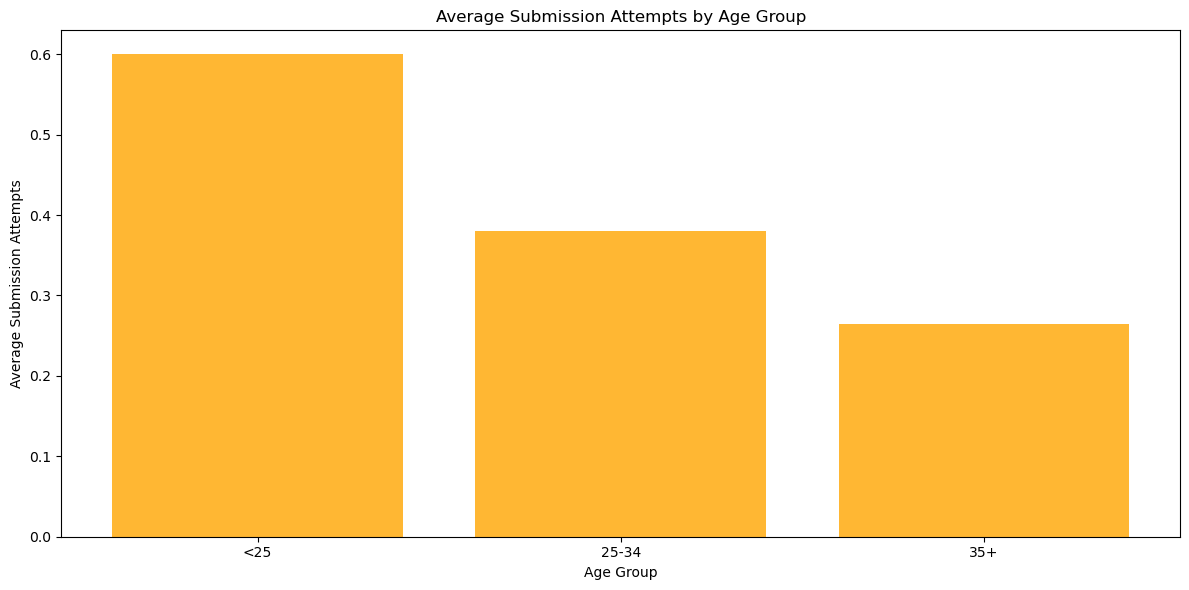

In [29]:
plt.figure(figsize=(12, 6))
plt.bar(technique_analysis['age_group'], technique_analysis['avg_control_time'], color='skyblue', alpha=0.8)
plt.xlabel('Age Group')
plt.ylabel('Average Control Time (seconds)')
plt.title('Average Control Time by Age Group')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(technique_analysis['age_group'], technique_analysis['avg_sub_attempts'], color='orange', alpha=0.8)
plt.xlabel('Age Group')
plt.ylabel('Average Submission Attempts')
plt.title('Average Submission Attempts by Age Group')
plt.tight_layout()
plt.show()

### Strike Locations and Win Predictions

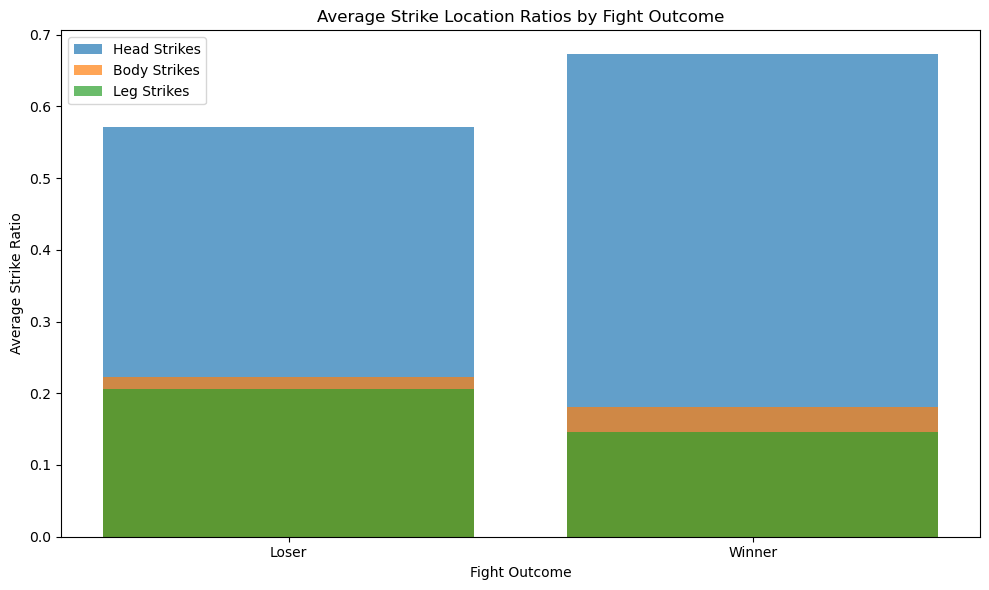

  outcome  avg_head_strike_ratio  avg_body_strike_ratio  avg_leg_strike_ratio
0   Loser               0.570866               0.222592              0.206542
1  Winner               0.672336               0.181429              0.146235


In [30]:
filtered_data = master_data[
    (master_data['head_strikes_landed'] >= 0) &
    (master_data['body_strikes_landed'] >= 0) &
    (master_data['leg_strikes_landed'] >= 0) &
    (master_data['result'].notna())
].copy()

filtered_data['total_strikes_landed'] = (
    filtered_data['head_strikes_landed'] +
    filtered_data['body_strikes_landed'] +
    filtered_data['leg_strikes_landed']
)
filtered_data['head_strike_ratio'] = filtered_data['head_strikes_landed'] / filtered_data['total_strikes_landed']
filtered_data['body_strike_ratio'] = filtered_data['body_strikes_landed'] / filtered_data['total_strikes_landed']
filtered_data['leg_strike_ratio'] = filtered_data['leg_strikes_landed'] / filtered_data['total_strikes_landed']

filtered_data['is_winner'] = filtered_data['result'].apply(lambda x: 1 if x == 1 else 0)
strike_analysis = filtered_data.groupby('is_winner').agg(
    avg_head_strike_ratio=('head_strike_ratio', 'mean'),
    avg_body_strike_ratio=('body_strike_ratio', 'mean'),
    avg_leg_strike_ratio=('leg_strike_ratio', 'mean')
).reset_index()

strike_analysis['outcome'] = strike_analysis['is_winner'].apply(lambda x: 'Winner' if x == 1 else 'Loser')

strike_locations = ['avg_head_strike_ratio', 'avg_body_strike_ratio', 'avg_leg_strike_ratio']
labels = ['Head Strikes', 'Body Strikes', 'Leg Strikes']

plt.figure(figsize=(10, 6))
for i, strike in enumerate(strike_locations):
    plt.bar(
        strike_analysis['outcome'],
        strike_analysis[strike],
        alpha=0.7,
        label=labels[i]
    )

plt.xlabel('Fight Outcome')
plt.ylabel('Average Strike Ratio')
plt.title('Average Strike Location Ratios by Fight Outcome')
plt.legend()
plt.tight_layout()
plt.show()

print(strike_analysis[['outcome', 'avg_head_strike_ratio', 'avg_body_strike_ratio', 'avg_leg_strike_ratio']])

In [32]:
filtered_data = master_data[(master_data['time'].notna()) & (master_data['method'].notna())].copy()
filtered_data['total_seconds'] = filtered_data['time'].apply(
    lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if isinstance(x, str) else x
)
duration_bins = [0, 300, 900, 1800]  # Short: <5 min, Medium: 5-15 min, Long: >15 min
duration_labels = ['Short (<5 min)', 'Medium (5-15 min)', 'Long (>15 min)']
filtered_data['duration_category'] = pd.cut(filtered_data['total_seconds'], bins=duration_bins, labels=duration_labels)
duration_analysis = filtered_data.groupby(['duration_category', 'method']).size().reset_index(name='count')
duration_analysis['proportion'] = duration_analysis.groupby('duration_category')['count'].transform(lambda x: x / x.sum())


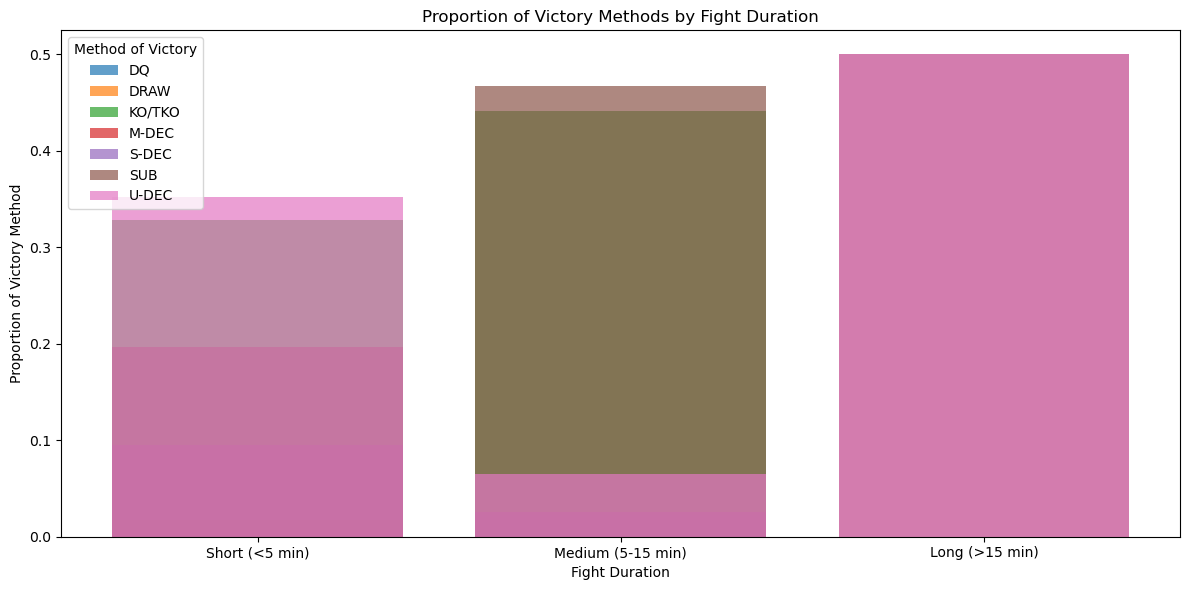

In [33]:
plt.figure(figsize=(12, 6))
for method in duration_analysis['method'].unique():
    subset = duration_analysis[duration_analysis['method'] == method]
    plt.bar(subset['duration_category'], subset['proportion'], label=method, alpha=0.7)

plt.xlabel('Fight Duration')
plt.ylabel('Proportion of Victory Method')
plt.title('Proportion of Victory Methods by Fight Duration')
plt.legend(title='Method of Victory')
plt.tight_layout()
plt.show()

In [35]:
print(duration_analysis)

    duration_category  method  count  proportion
0      Short (<5 min)      DQ     40    0.003028
1      Short (<5 min)    DRAW    232    0.017562
2      Short (<5 min)  KO/TKO   4343    0.328766
3      Short (<5 min)   M-DEC     96    0.007267
4      Short (<5 min)   S-DEC   1250    0.094625
5      Short (<5 min)     SUB   2597    0.196593
6      Short (<5 min)   U-DEC   4652    0.352157
7   Medium (5-15 min)      DQ      0    0.000000
8   Medium (5-15 min)    DRAW      0    0.000000
9   Medium (5-15 min)  KO/TKO     34    0.441558
10  Medium (5-15 min)   M-DEC      0    0.000000
11  Medium (5-15 min)   S-DEC      2    0.025974
12  Medium (5-15 min)     SUB     36    0.467532
13  Medium (5-15 min)   U-DEC      5    0.064935
14     Long (>15 min)      DQ      0    0.000000
15     Long (>15 min)    DRAW      0    0.000000
16     Long (>15 min)  KO/TKO      0    0.000000
17     Long (>15 min)   M-DEC      0    0.000000
18     Long (>15 min)   S-DEC      0    0.000000
19     Long (>15 min

In [36]:
master_data['date'] = pd.to_datetime(master_data['date'])
master_data['total_seconds'] = master_data['time'].apply(
    lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]) if isinstance(x, str) else x
)
long_fight_data = master_data[master_data['total_seconds'] > 900].copy()

master_data = master_data.sort_values(by=['fighter', 'date'])
master_data['fight_gap'] = master_data.groupby('fighter')['date'].diff().dt.days

fighter_long_fight_counts = long_fight_data.groupby('fighter').size().reset_index(name='long_fight_count')
fighter_long_fight_counts['frequent_long_fights'] = fighter_long_fight_counts['long_fight_count'].apply(
    lambda x: 'Frequent Long Fights' if x > 3 else 'Rare Long Fights'
)

master_data = master_data.merge(fighter_long_fight_counts[['fighter', 'frequent_long_fights']], on='fighter', how='left')
master_data['frequent_long_fights'] = master_data['frequent_long_fights'].fillna('No Long Fights')

gap_analysis = master_data.groupby('frequent_long_fights')['fight_gap'].mean().reset_index()


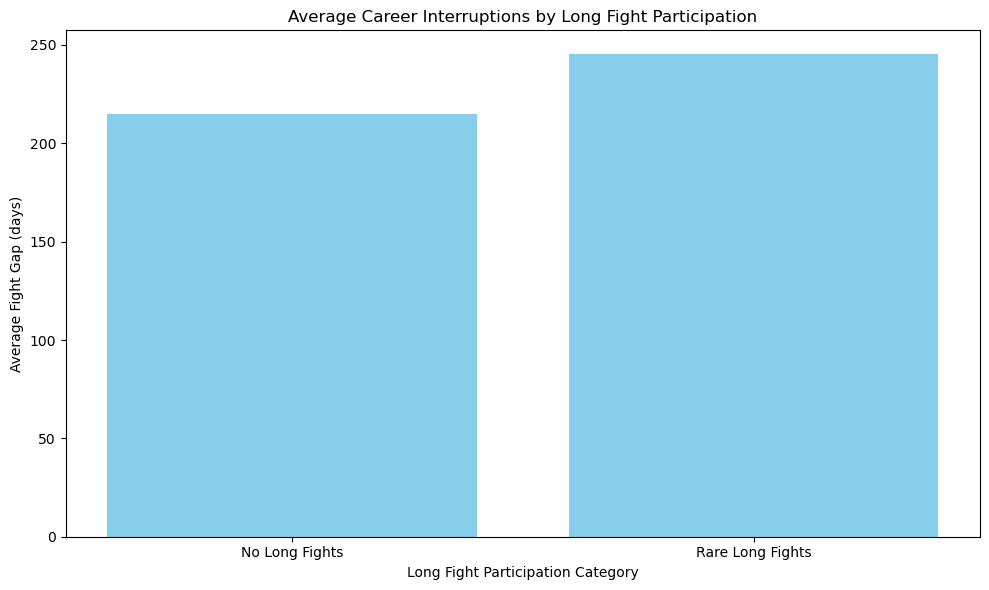

In [37]:
plt.figure(figsize=(10, 6))
plt.bar(gap_analysis['frequent_long_fights'], gap_analysis['fight_gap'], color='skyblue')
plt.xlabel('Long Fight Participation Category')
plt.ylabel('Average Fight Gap (days)')
plt.title('Average Career Interruptions by Long Fight Participation')
plt.tight_layout()
plt.show()

In [38]:
print(gap_analysis)

  frequent_long_fights   fight_gap
0       No Long Fights  215.164894
1     Rare Long Fights  245.195652


In [43]:
filtered_data = master_data[
    (master_data['control'] >= 0) &
    (master_data['sig_strikes_landed'].notna()) &
    (master_data['method'].notna())
].copy()

control_bins = [0, 60, 300, float('inf')]  # Low: <1 min, Medium: 1-5 min, High: >5 min
control_labels = ['Low (<1 min)', 'Medium (1-5 min)', 'High (>5 min)']
filtered_data['control_category'] = pd.cut(filtered_data['control'], bins=control_bins, labels=control_labels)

control_analysis = filtered_data.groupby('control_category').agg(
    avg_sig_strikes=('sig_strikes_landed', 'mean'),
    ko_tko_count=('method', lambda x: sum(x == 'KO/TKO')),
    total_fights=('method', 'count')
).reset_index()

control_analysis['ko_tko_proportion'] = control_analysis['ko_tko_count'] / control_analysis['total_fights']


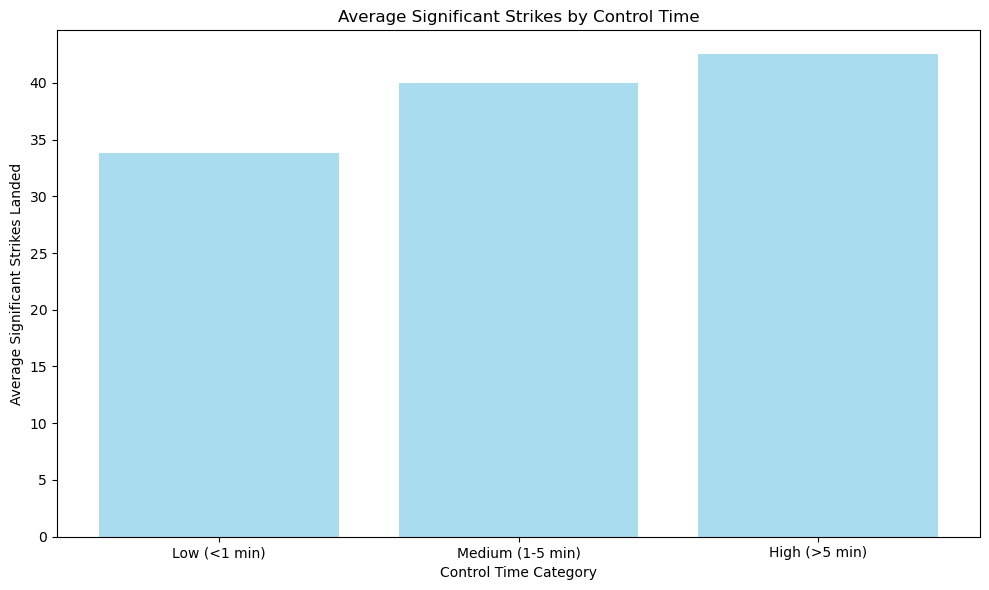

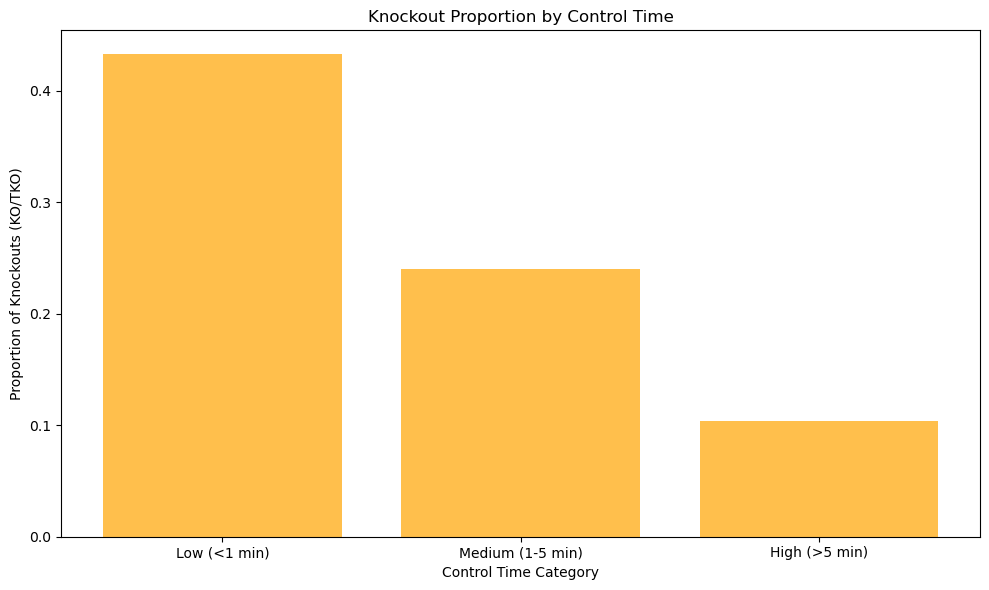

   control_category  avg_sig_strikes  ko_tko_count  total_fights  \
0      Low (<1 min)        33.852381          1907          4410   
1  Medium (1-5 min)        40.005077          1088          4530   
2     High (>5 min)        42.496761           208          2007   

   ko_tko_proportion  
0           0.432426  
1           0.240177  
2           0.103637  


In [45]:
plt.figure(figsize=(10, 6))
plt.bar(control_analysis['control_category'], control_analysis['avg_sig_strikes'], color='skyblue', alpha=0.7)
plt.xlabel('Control Time Category')
plt.ylabel('Average Significant Strikes Landed')
plt.title('Average Significant Strikes by Control Time')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(control_analysis['control_category'], control_analysis['ko_tko_proportion'], color='orange', alpha=0.7)
plt.xlabel('Control Time Category')
plt.ylabel('Proportion of Knockouts (KO/TKO)')
plt.title('Knockout Proportion by Control Time')
plt.tight_layout()
plt.show()

print(control_analysis)